<div style="max-width:1200px"><img src="../_resources/mgnify_banner.png" width="100%"></div>

<img src="../_resources/mgnify_logo.png" width="200px">

# Cross-Study analysis, using MGnifyR

The [MGnify API](https://www.ebi.ac.uk/metagenomics/api/v1) returns data and relationships as JSON. 
[MGnifyR](https://github.com/beadyallen/MGnifyR) is a package to help you read MGnify data into your R analyses.

**This example shows you how to perform an analysis across multiple Studies. It is an example of comparing taxonomic diversity from two places in different Studies.**

You can also discover more about the "API" using the [Browsable API interface in your web browser](https://www.ebi.ac.uk/metagenomics/api/v1).

This is an interactive code notebook (a Jupyter Notebook).
To run this code, click into each cell and press the ▶ button in the top toolbar, or press `shift+enter`.

---

In [1]:
library(IRdisplay)
display_markdown(file = '../_resources/mgnifyr_help.md')

# Help with MGnifyR

MGnifyR is an R package that provides a convenient way for R users to access data from [the MGnify API](https://www.ebi.ac.uk/metagenomics/api/).

Detailed help for each function is available in R using the standard `?function_name` command (i.e. typing `?mgnify_query` will bring up built-in help for the mgnify_query command). 

A vignette is available containing a reasonably verbose overview of the main functionality. 
This can be read either within R with the `vignette("MGnifyR")` command, or [in the development repository](https://htmlpreview.github.io/?https://github.com/beadyallen/MGnifyR/blob/master/doc/MGnifyR.html)

## MGnifyR Command cheat sheet

The following list of key functions should give a starting point for finding relevent documentation.

- `mgnify_client()` : Create the client object required for all other functions.
- `mgnify_query()` : Search the whole MGnify database.
- `mgnify_analyses_from_xxx()` : Convert xxx accessions to analyses accessions. xxx is either samples or studies.
- `mgnify_get_analyses_metadata()` : Retrieve all study, sample and analysis metadata for given analyses.
- `mgnify_get_analyses_phyloseq()` : Convert abundance, taxonomic, and sample metadata into a single phyloseq object.
- `mgnify_get_analyses_results()` : Get functional annotation results for a set of analyses.
- `mgnify_download()` : Download raw results files from MGnify.
- `mgnify_retrieve_json()` : Low level API access helper function.


Load libraries:

In [1]:
library(vegan)
library(ggplot2)
library(phyloseq)
library(MGnifyR)
library(SIAMCAT)
library(metagenomeSeq, quietly = T)

mg <- mgnify_client(usecache = T, cache_dir = '/tmp/mgnify_cache')

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7

Loading required package: mlr

Loading required package: ParamHelpers

Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bio

# Example: compare taxonomic abundances of two soil studies
*This example is based on a [MGnify workshop exercise](https://beadyallen.github.io/MGnifyR/Exercises.html) created by [Ben Allen](https://github.com/beadyallen) (the author of MGnifyR).*

## Fetch the MGnify Analyses accessions for each of two Studies
(one with samples from Malaysia, one with samples from Panama)

In [3]:
panama <- mgnify_analyses_from_studies(mg, 'MGYS00003920')
malaysia <- mgnify_analyses_from_studies(mg, 'MGYS00003918')

  |======================================================================| 100%
  |======================================================================| 100%


Join the Analyses accession lists

In [4]:
accessions <- c(panama, malaysia)
sprintf('There are %d accessions between the studies', length(accessions))

[1] "There are 78 accessions between the studies"

Fetch metadata for all of the Analyses from the MGnify API

In [5]:
metadata <- mgnify_get_analyses_metadata(mg, accessions)
head(metadata)

  |======================================================================| 100%


,analysis_experiment-type,analysis_accession,analysis_analysis-status,analysis_pipeline-version,analysis_complete-time,analysis_instrument-platform,analysis_instrument-model,analysis_Submitted nucleotide sequences,analysis_Nucleotide sequences after format-specific filtering,analysis_Nucleotide sequences after length filtering,⋯,sample_depth,sample_elevation,sample_pH,sample_geographic location (latitude),sample_instrument model,sample_ENA checklist,sample_last update date,sample_acc_type,run_accession,biome_string
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
MGYA00329605,unknown,MGYA00329605,completed,4.1,2019-03-06T00:00:00,ILLUMINA,Illumina MiSeq,120,120,118,⋯,0.0-0.2,53.0,3.3,8.971447,Illumina MiSeq,ERC000011,2017-02-18,samples,ERR1844693,root:Environmental:Terrestrial:Soil
MGYA00329606,unknown,MGYA00329606,completed,4.1,2019-03-06T00:00:00,ILLUMINA,Illumina MiSeq,27607,27607,27233,⋯,0.0-0.2,120.0,6.4,9.1442795,Illumina MiSeq,ERC000011,2017-02-18,samples,ERR1844694,root:Environmental:Terrestrial:Soil
MGYA00329607,unknown,MGYA00329607,completed,4.1,2019-03-06T00:00:00,ILLUMINA,Illumina MiSeq,25238,25238,24806,⋯,0.0-0.2,120.0,5.6,9.1442795,Illumina MiSeq,ERC000011,2017-02-18,samples,ERR1844695,root:Environmental:Terrestrial:Soil
MGYA00329608,unknown,MGYA00329608,completed,4.1,2019-03-06T00:00:00,ILLUMINA,Illumina MiSeq,5,5,5,⋯,0.0-0.2,53.0,3.6,8.971447,Illumina MiSeq,ERC000011,2017-02-18,samples,ERR1844696,root:Environmental:Terrestrial:Soil
MGYA00329609,unknown,MGYA00329609,completed,4.1,2019-03-06T00:00:00,ILLUMINA,Illumina MiSeq,20805,20805,20464,⋯,0.0-0.2,155.0,6.9,9.080094,Illumina MiSeq,ERC000011,2017-02-18,samples,ERR1844697,root:Environmental:Terrestrial:Soil
MGYA00329610,unknown,MGYA00329610,completed,4.1,2019-03-06T00:00:00,ILLUMINA,Illumina MiSeq,21171,21171,20834,⋯,0.0-0.2,64.0,6.3,8.908218,Illumina MiSeq,ERC000011,2017-02-18,samples,ERR1844698,root:Environmental:Terrestrial:Soil


## Taxonomic analysis
First, build a [phyloseq](https://joey711.github.io/phyloseq/) object of the Analyses metadata

In [6]:
ps <- mgnify_get_analyses_phyloseq(mg, metadata$analysis_accession)

  |======================================================================| 100%


#### Filter out low-abundance samples
Filter out samples with low abundances, leaving just those in the "normal" distribution. This is particularly important given the normalisation approach we're about to use ([`phyloseq`'s slightly controversial `rarefy_even_depth`](https://www.rdocumentation.org/packages/phyloseq/versions/1.16.2/topics/rarefy_even_depth).)

We make a histogram and note that samples with abundances $\lt 10^3$ i.e. $\lt 1000$ seem to be outliers.

In [2]:
hist(log10(sample_sums(ps)), breaks = 50)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'object' in selecting a method for function 'otu_table': object 'ps' not found


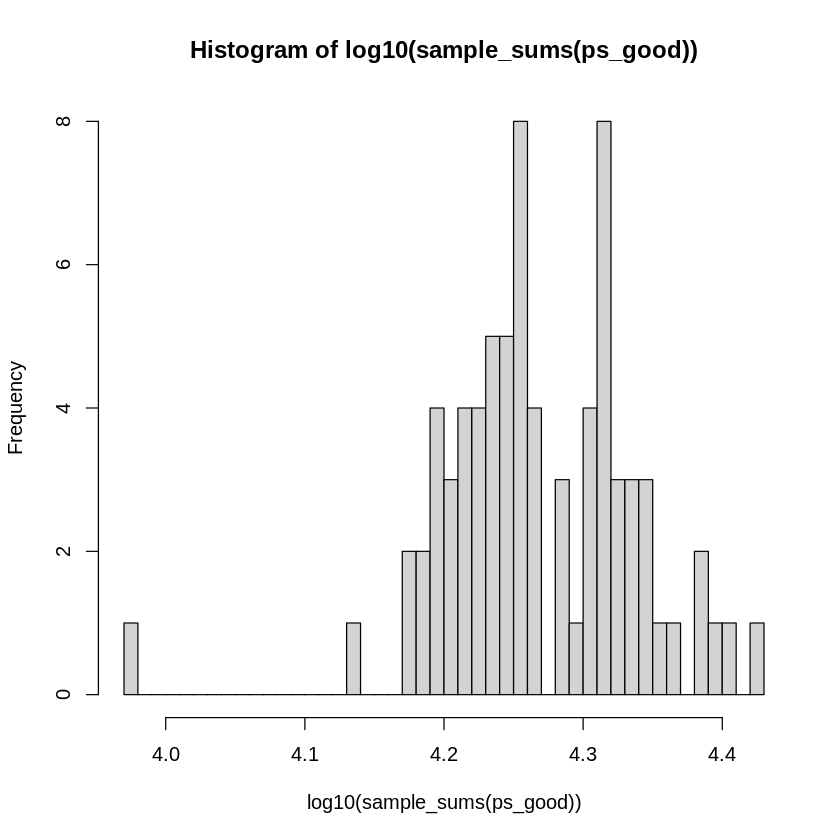

In [12]:
ps_good <- subset_samples(ps, sample_sums(ps) > 1000)
hist(log10(sample_sums(ps_good)), breaks = 50)

#### Estimate richness

Use `estimate_richness` to calculate various diversity measures for each analysis.

To read the documentation on this method, enter `?estimate_richness` in a Code Cell and run it.

In [ ]:
#  ?estimate_richness

In [ ]:
diversity = estimate_richness(ps_good)
head(diversity)

diversity[diversity$Observed == max(diversity$Observed),]

#### Normalise the data by rarefication

In [ ]:
ps_rare <- rarefy_even_depth(ps_good)
div_rare <- estimate_richness(ps_rare)

In [ ]:
merged_df <- merge(div_rare, metadata, by = 0, all.y = F)
head(merged_df)

In [ ]:
options(repr.plot.width=12, repr.plot.height=8)
ggplot(merged_df, aes(x=`sample_geo-loc-name`, y=Observed)) + geom_boxplot() + theme(text = element_text(size = 20))

In [3]:
create.label?

ERROR: Error in parse(text = x, srcfile = src): <text>:2:0: unexpected end of input
1: create.label?
   ^


In [4]:
?create.label

create.label {SIAMCAT},R Documentation
label,named vector to create the label or the name of the metadata column that will be used to create the label
case,"name of the group that will be used as a positive label. If the variable is binary, the other label will be used as a negative one. If the variable has multiple values, all the other values will be used a negative label (testing one vs rest)."
meta,metadata dataframe object or an object of class sample_data-class
control,"name of a label or vector with names that will be used as a negative label. All values that are nor equal to case and control will be dropped. Default to NULL in which case: If the variable is binary, the value not equal to case will be used as negative. If the variable has multiple values, all the values not equal to cases will be used a negative label (testing one vs rest)."
p.lab,name of the positive group (useful mostly for visualizations). Default to NULL in which case the value of the positive group will be used.
n.lab,"name of the negative group (useful mostly for visualizations). Default to NULL in which case the value of the negative group will be used for binary variables and ""rest"" will be used for variables with multiple values."
remove.meta.column,"boolean indicating if the label column in the metadata should be retained. Please note that if this is set to TRUE, the function will return a list as result. Defaults to FALSE"
verbose,"integer, control output: 0 for no output at all, 1 for only information about progress and success, 2 for normal level of information and 3 for full debug information, defaults to 1"


In [7]:
accessions_prePS=metadata$analysis_accession

In [8]:
accessions_postPS=sample_names(ps)

In [9]:
length(accessions_prePS)
length(accessions_postPS)

[1] 78

[1] 77

In [10]:
setdiff(accessions_prePS, accessions_postPS)

[1] "MGYA00329556"

In [13]:
length(sample_names(ps_good))

[1] 75